# CV Project
### SP23-BAI-035
### SP23-BAI-031
### SP23-BAI-042
### NLP - A4
# Image captioning (Image feature extraction + caption prediction)

##### 1. Import required libraries

In [4]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, get_file
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.utils import plot_model


# small library for seeing the progress of loops.
from tqdm.notebook import tqdm
tqdm().pandas()


0it [00:00, ?it/s]

In [5]:
# Paths
dataset_text = "Flickr8k_text"
dataset_images = "Flicker8k_Dataset"
saved_dir = "saved/"
models_dir = "models/"

##### 2. Loading and Preprocesssing data

In [6]:

# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


##### 2.1 Preparing text data

In [7]:
# prepare text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

Length of descriptions = 8092


In [8]:
#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

Length of vocabulary =  8763


In [9]:
#saving each description to file 
save_descriptions(clean_descriptions, saved_dir + "descriptions.txt")

##### 2.2 Load Model for feature extraction

In [10]:
# Load
weights_path = models_dir + 'xception_weights.h5'
model = Xception(include_top=False, pooling='avg', weights=weights_path)

2025-12-17 11:19:12.914729: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:

def extract_features(directory):
    features = {}
    valid_images = ['.jpg', '.jpeg', '.png']
    
    for img in tqdm(os.listdir(directory)):
        ext = os.path.splitext(img)[1].lower()
        if ext not in valid_images:
            continue
            
        filename = directory + "/" + img
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0

        feature = model.predict(image)
        features[img] = feature
    return features


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


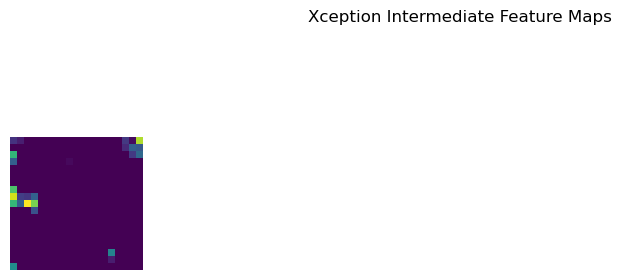

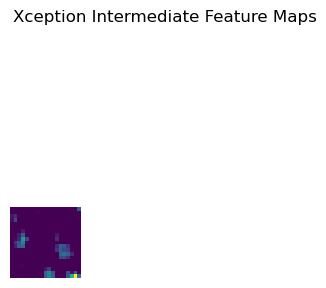

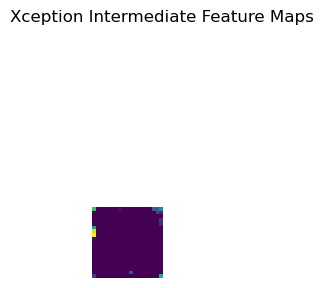

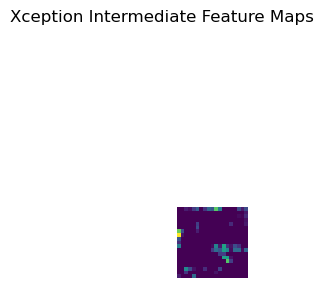

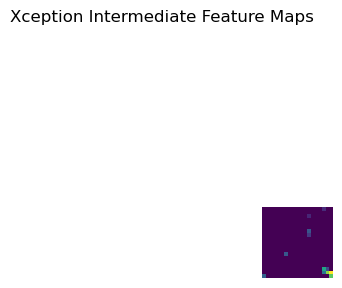

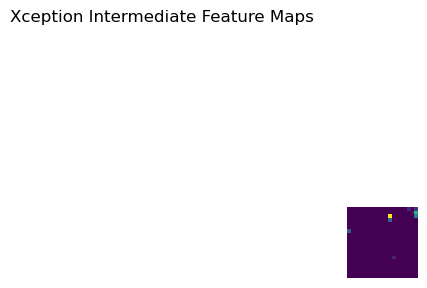

In [12]:
# Visualizing intermediate feature maps from Xception
from keras.models import Model
import matplotlib.pyplot as plt


# Pick an intermediate layer
layer_name = 'block13_sepconv2_act'
intermediate_model = Model(inputs=model.input,
outputs=model.get_layer(layer_name).output)


# Load a sample image
sample_img_path = dataset_images + '/1000268201_693b08cb0e.jpg'
img = Image.open(sample_img_path).resize((299, 299))
img = np.expand_dims(img, axis=0)
img = img / 127.5 - 1.0


# Extract feature maps
feature_maps = intermediate_model.predict(img)


# Plot first 6 feature maps
plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(feature_maps[0,:,:,i], cmap='viridis')
    plt.axis('off')
    plt.suptitle('Xception Intermediate Feature Maps')
    plt.show()

In [12]:

# 2048 feature vector
# features = extract_features(dataset_images)
# dump(features, open(saved_dir + "features.p","wb"))


In [13]:
features = load(open(saved_dir + "features.p","rb"))

##### 2.3 Load image data

In [14]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    photos_present = [photo for photo in photos if os.path.exists(os.path.join(dataset_images, photo))]
    return photos_present


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open(saved_dir + "features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

##### 3. Preparing train data

In [15]:

filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions(saved_dir + "descriptions.txt", train_imgs)
train_features = load_features(train_imgs)
print(train_descriptions)

#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


{'1000268201_693b08cb0e.jpg': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>', '<start> girl going into wooden building <end>', '<start> little girl climbing into wooden playhouse <end>', '<start> little girl climbing the stairs to her playhouse <end>', '<start> little girl in pink dress going into wooden cabin <end>'], '1001773457_577c3a7d70.jpg': ['<start> black dog and spotted dog are fighting <end>', '<start> black dog and tricolored dog playing with each other on the road <end>', '<start> black dog and white dog with brown spots are staring at each other in the street <end>', '<start> two dogs of different breeds looking at each other on the road <end>', '<start> two dogs on pavement moving toward each other <end>'], '1002674143_1b742ab4b8.jpg': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>', '<start> little girl is sitting in front of large painted rainbow <end>', '<start> small girl in the g

##### 3.1 creating tokenizer

In [16]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max((len(d.split()) for d in desc_list))
    

In [17]:
print(train_descriptions)
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open(saved_dir + 'tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

    
max_length = max_length(train_descriptions)
print(max_length)


{'1000268201_693b08cb0e.jpg': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>', '<start> girl going into wooden building <end>', '<start> little girl climbing into wooden playhouse <end>', '<start> little girl climbing the stairs to her playhouse <end>', '<start> little girl in pink dress going into wooden cabin <end>'], '1001773457_577c3a7d70.jpg': ['<start> black dog and spotted dog are fighting <end>', '<start> black dog and tricolored dog playing with each other on the road <end>', '<start> black dog and white dog with brown spots are staring at each other in the street <end>', '<start> two dogs of different breeds looking at each other on the road <end>', '<start> two dogs on pavement moving toward each other <end>'], '1002674143_1b742ab4b8.jpg': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>', '<start> little girl is sitting in front of large painted rainbow <end>', '<start> small girl in the g

##### 3.2 create input-output sequence pairs from the image description.


In [18]:
#data generator, used by model.fit()
def data_generator(descriptions, features, tokenizer, max_length):
    def generator():
        while True:
            for key, description_list in descriptions.items():
                feature = features[key][0]
                input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
                for i in range(len(input_image)):
                    yield {'input_1': input_image[i], 'input_2': input_sequence[i]}, output_word[i]
    
    # Define the output signature for the generator
    output_signature = (
        {
            'input_1': tf.TensorSpec(shape=(2048,), dtype=tf.float32),
            'input_2': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
    )
    
    # Create the dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )
    
    return dataset.batch(32)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


In [19]:
dataset = data_generator(train_descriptions, features, tokenizer, max_length)
for (a, b) in dataset.take(1):
    print(a['input_1'].shape, a['input_2'].shape, b.shape)
    break


(32, 2048) (32, 34) (32, 7577)


### 4. Tranning phase


##### 3.1  Define the captioning model

In [20]:
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  34


In [21]:
model = define_model(vocab_size, max_length)
epochs = 10

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2             │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  1,939,712 │ input_2[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_2[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7577)      │  1,947,289 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,002,649 (19.08 MB)

 Trainable params: 5,002,649 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


##### 3.2 Tranning 

In [22]:

def get_steps_per_epoch(train_descriptions):
    total_sequences = 0
    for img_captions in train_descriptions.values():
        for caption in img_captions:
            words = caption.split()
            total_sequences += len(words) - 1
    # Ensure at least 1 step, even if sequences < batch_size
    return max(1, total_sequences // 32)

# Update training loop
steps = get_steps_per_epoch(train_descriptions)


In [24]:

# making a directory models to save our models
os.mkdir("models2")
for i in range(epochs):
    dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(dataset, epochs=4, steps_per_epoch=steps, verbose=1)
    model.save("models2/model_" + str(i) + ".h5")

Epoch 1/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1440s 150ms/step - loss: 4.4642
Epoch 2/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1420s 148ms/step - loss: 3.6852
Epoch 3/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1468s 153ms/step - loss: 3.4424
Epoch 4/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1448s 151ms/step - loss: 3.3080


Epoch 1/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1394s 146ms/step - loss: 3.2210
Epoch 2/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1430s 149ms/step - loss: 3.1617
Epoch 3/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1525s 159ms/step - loss: 3.1190
Epoch 4/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1456s 152ms/step - loss: 3.0833


Epoch 1/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1542s 161ms/step - loss: 3.0599
Epoch 2/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1623s 170ms/step - loss: 3.0382
Epoch 3/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1466s 153ms/step - loss: 3.0263
Epoch 4/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1397s 146ms/step - loss: 3.0194


Epoch 1/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1390s 145ms/step - loss: 3.0048
Epoch 2/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1388s 145ms/step - loss: 2.9981
Epoch 3/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1391s 145ms/step - loss: 2.9936
Epoch 4/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1391s 145ms/step - loss: 2.9931


Epoch 1/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1389s 145ms/step - loss: 2.9891
Epoch 2/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1386s 145ms/step - loss: 2.9916
Epoch 3/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1391s 145ms/step - loss: 2.9878
Epoch 4/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1393s 145ms/step - loss: 2.9881


Epoch 1/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1387s 145ms/step - loss: 2.9914
Epoch 2/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1395s 146ms/step - loss: 2.9899
Epoch 3/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1393s 145ms/step - loss: 2.9970
Epoch 4/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1393s 146ms/step - loss: 2.9974


Epoch 1/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1390s 145ms/step - loss: 3.0026
Epoch 2/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1429s 149ms/step - loss: 3.0053
Epoch 3/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1437s 150ms/step - loss: 3.0097
Epoch 4/4
9575/9575 ━━━━━━━━━━━━━━━━━━━━ 1431s 149ms/step - loss: 3.0110


Epoch 1/4
8120/9575 ━━━━━━━━━━━━━━━━━━━━ 3:38 150ms/step - loss: 3.0069

KeyboardInterrupt: 